In [1]:
import crossref_commons.retrieval
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from src.crossref import current_timestamp
from src.github_api import ReplicationCode
from time import sleep

# GitHub API

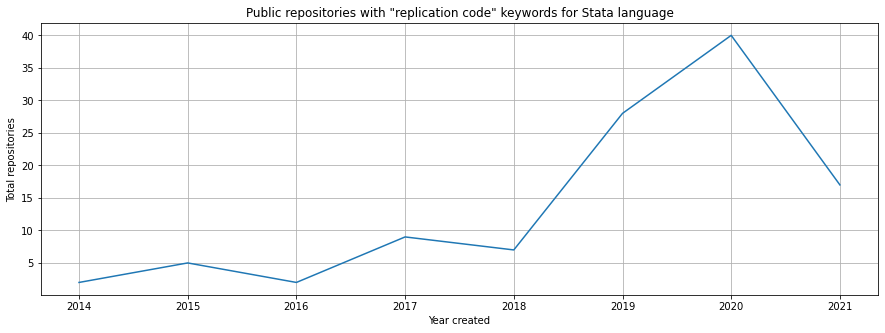

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-05-31 02:18:06: https://www.aeaweb.org/journals/aer/issues
2021-05-31 02:18:07: https://www.aeaweb.org/journals/aeri/issues
2021-05-31 02:18:08: https://www.aeaweb.org/journals/app/issues
2021-05-31 02:18:10: https://www.aeaweb.org/journals/pol/issues
2021-05-31 02:18:11: https://www.aeaweb.org/journals/mac/issues
2021-05-31 02:18:12: https://www.aeaweb.org/journals/mic/issues
2021-05-31 02:18:13: https://www.aeaweb.org/journals/jel/issues
2021-05-31 02:18:15: https://www.aeaweb.org/journals/jep/issues
2021-05-31 02:18:16: https://www.aeaweb.org/journals/pandp/issues


In [4]:
aea = os.listdir('data/aea/raw')

In [5]:
def dataframe(file):
    with open(f'data/aea/raw/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df['year'] = df.publication_date.apply(lambda x: x[-4:])
df['year'] = df.year.astype(str)

In [7]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [8]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

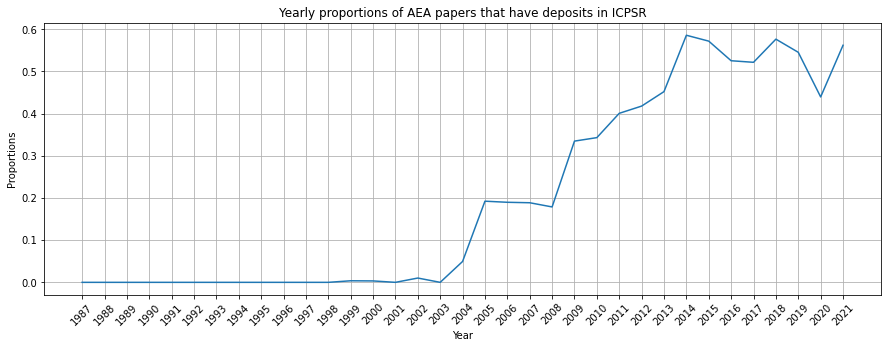

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xticks(rotation = 45)
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')

# Top 10 econ journals

In [10]:
def check_column(data, column):
    try:
        return data[column]
    except KeyError:
        return None
    
def dataframe(path, journal, file_name):
    df = []
    for j in journal:
        with open(f'{path}/{j}', 'r') as f:
            data = json.load(f)
            url = data['URL']
            print(f'{current_timestamp()}: {url}')
            d = {
                'doi': url,
                'title': check_column(data, 'title'),
                'author': check_column(data, 'author'),
                'publisher': check_column(data, 'publisher'),
                'created': check_column(data, 'created'),
                'has_replication': has_replication(url)

            }
            df.append(d)

    pd.DataFrame(df).to_csv(f'data/has-replication/{file_name}.csv', index=False)

## American Economic Association

AEA has three journals that are listed in top 10 econ journals according to IDEAS/RePEc. They are:
- American Economic Review (#1)
- Journal of Economic Literature (#2)
- Journal of Economic Perspectives (#10)

In [11]:
path = 'data/aea/raw'
os.system(f'rm -rf {path}/.ipynb_checkpoints')
aea = os.listdir(path)
aea = [json.load(open(f'{path}/{x}', 'r')) for x in aea]

In [12]:
for i in aea:
    for j in i['article']:
        j.update({'publication_date': i['publication_date']})

In [13]:
def has_replication(journal, file_name):
    df = pd.concat([pd.DataFrame(x['article']) for x in aea], sort=False)
    df = df.reset_index(drop=True)
    df['has_replication'] = df.icpsr.apply(lambda x: x != None)
    df[journal] = df.url.apply(lambda x: f'{journal}.' in x.lower())
    df = df[df[journal] == True]
    df = df[['url', 'icpsr', 'publication_date', 'has_replication']]
    df = df.reset_index(drop=True)
    df.to_csv(f'data/has-replication/{file_name}.csv', index=False)
    
has_replication('aer', 'american-economic-review')
has_replication('jel', 'journal-of-economic-literature')
has_replication('jep', 'journal-of-economic-perspectives')

## 3. The Quarterly Journal of Economics

In [14]:
path = 'data/crossref/s-oup-qjecon'
qje = os.listdir(path)

def has_replication(url):
    '''
    DOI example that has supplementary data: https://doi.org/10.1093/qje/qjaa038
    DOI example that doesn't have any supplementary data: http://dx.doi.org/10.1093/qje/qjr049
    '''

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            return content.find('h2', {'id': 'supplementary-data'}) != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, qje, 'the-quarterly-journal-of-economics')

2021-05-31 02:18:20: http://dx.doi.org/10.1093/qje/121.1.229
2021-05-31 02:18:22: http://dx.doi.org/10.1162/qjec.122.3.1067
2021-05-31 02:18:24: http://dx.doi.org/10.1093/qje/qjz038
2021-05-31 02:18:27: http://dx.doi.org/10.1093/qje/121.4.1167
2021-05-31 02:18:28: http://dx.doi.org/10.1162/003355303322552775
2021-05-31 02:18:30: http://dx.doi.org/10.1162/003355301753265561
2021-05-31 02:18:32: http://dx.doi.org/10.1162/00335530360535171
2021-05-31 02:18:35: http://dx.doi.org/10.1162/003355302753399481
2021-05-31 02:18:36: http://dx.doi.org/10.1162/qjec.122.2.729
2021-05-31 02:18:38: http://dx.doi.org/10.1093/qje/qjx042
2021-05-31 02:18:40: http://dx.doi.org/10.1162/003355305775097579
2021-05-31 02:18:42: http://dx.doi.org/10.1162/00335530152466250
2021-05-31 02:18:44: http://dx.doi.org/10.1093/qje/121.1.1
2021-05-31 02:18:46: http://dx.doi.org/10.1162/qjec.2009.124.4.1675
2021-05-31 02:18:48: http://dx.doi.org/10.1093/qje/qjv028
2021-05-31 02:18:50: http://dx.doi.org/10.1162/qjec.2006.

## 5. Journal of Political Economy

In [15]:
path = 'data/crossref/s-ucp-jpolec'
jpolec = os.listdir(path)

def has_replication(url):
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            sleep(1)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            div = content.find('div', {'class': 'article__navbar__row tos-list__wrapper'})
            try:
                return 'supplemental material' in [x.text.lower() for x in div.find_all('li')]
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, jpolec, 'journal-of-political-economy')

2021-05-31 02:21:50: http://dx.doi.org/10.1086/675910
2021-05-31 02:21:53: http://dx.doi.org/10.1086/699018
2021-05-31 02:21:55: http://dx.doi.org/10.1086/679498
2021-05-31 02:21:57: http://dx.doi.org/10.1086/712507
2021-05-31 02:22:00: http://dx.doi.org/10.1086/704386
2021-05-31 02:22:03: http://dx.doi.org/10.1086/519927
2021-05-31 02:22:05: http://dx.doi.org/10.1086/712736
2021-05-31 02:22:08: http://dx.doi.org/10.1086/666526
2021-05-31 02:22:11: http://dx.doi.org/10.1086/683838
2021-05-31 02:22:13: http://dx.doi.org/10.1086/702018
2021-05-31 02:22:15: http://dx.doi.org/10.1086/597025
2021-05-31 02:22:18: http://dx.doi.org/10.1086/690950
2021-05-31 02:22:21: http://dx.doi.org/10.1086/424740
2021-05-31 02:22:23: http://dx.doi.org/10.1086/700761
2021-05-31 02:22:25: http://dx.doi.org/10.1086/699975
2021-05-31 02:22:28: http://dx.doi.org/10.1086/660298
2021-05-31 02:22:30: http://dx.doi.org/10.1086/705670
2021-05-31 02:22:33: http://dx.doi.org/10.1086/699188
2021-05-31 02:22:35: http://

## 6. Journal of Economic Growth 

In [16]:
path = 'data/crossref/s-kap-jecgro'
jecgro = os.listdir(path)

def has_replication(url):
    '''
    DOI example with Electronic supplementary material: https://doi.org/10.1007/s10887-020-09183-6
    DOI example with Supplementary Information: https://doi.org/10.1007/s10887-020-09185-4
    '''
    
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplement = lambda keyword: content.find('section', {'data-title': keyword}).text.lower()
            try:
                return 'supplementary material' in supplement('Electronic supplementary material')
            except AttributeError:
                try:
                    return 'supplementary material' in supplement('Supplementary Information')
                except AttributeError:
                    return False
            except Exception as e:
                print(f'{current_timestamp()}: {url} has an error -> {e}')
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass

dataframe(path, jecgro, 'journal-of-economic-growth')

2021-05-31 02:47:43: http://dx.doi.org/10.1007/s10887-018-9160-8
2021-05-31 02:47:45: http://dx.doi.org/10.1007/s10887-019-09171-5
2021-05-31 02:47:46: http://dx.doi.org/10.1007/s10887-006-9005-8
2021-05-31 02:47:47: http://dx.doi.org/10.1007/s10887-011-9070-5
2021-05-31 02:47:48: http://dx.doi.org/10.1007/s10887-016-9131-x
2021-05-31 02:47:50: http://dx.doi.org/10.1007/s10887-009-9036-z
2021-05-31 02:47:51: http://dx.doi.org/10.1007/s10887-010-9051-0
2021-05-31 02:47:52: http://dx.doi.org/10.1007/s10887-017-9146-y
2021-05-31 02:47:53: http://dx.doi.org/10.1007/s10887-006-9000-0
2021-05-31 02:47:55: http://dx.doi.org/10.1007/s10887-019-09166-2
2021-05-31 02:47:56: http://dx.doi.org/10.1007/s10887-008-9031-9
2021-05-31 02:47:58: http://dx.doi.org/10.1007/s10887-016-9134-7
2021-05-31 02:47:59: http://dx.doi.org/10.1007/s10887-015-9111-6
2021-05-31 02:48:01: http://dx.doi.org/10.1007/s10887-011-9061-6
2021-05-31 02:48:02: http://dx.doi.org/10.1007/s10887-020-09183-6
2021-05-31 02:48:03: h

## 7. Review of Financial Studies

In [17]:
path = 'data/crossref/s-oup-rfinst'
rfinst = os.listdir(path)

def has_replication(url):

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            print(res)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplementary = content.find('h2', {'id': 'supplementary-data'})
            return supplementary != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, rfinst, 'the-review-of-financial-studies')

2021-05-31 02:52:00: http://dx.doi.org/10.1093/rfs/hhw103
<Response [200]>
2021-05-31 02:52:01: http://dx.doi.org/10.1093/rfs/hhy083
<Response [200]>
2021-05-31 02:52:01: http://dx.doi.org/10.1093/rfs/hht014
<Response [200]>
2021-05-31 02:52:01: http://dx.doi.org/10.1093/rfs/hhy104
<Response [200]>
2021-05-31 02:52:02: http://dx.doi.org/10.1093/rfs/hhu047
<Response [200]>
2021-05-31 02:52:03: http://dx.doi.org/10.1093/rfs/hht025
<Response [200]>
2021-05-31 02:52:03: http://dx.doi.org/10.1093/rfs/hhy019
<Response [200]>
2021-05-31 02:52:03: http://dx.doi.org/10.1093/rfs/hhw026
<Response [200]>
2021-05-31 02:52:04: http://dx.doi.org/10.1093/rfs/hhu044
<Response [200]>
2021-05-31 02:52:04: http://dx.doi.org/10.1093/rfs/hhy097
<Response [200]>
2021-05-31 02:52:04: http://dx.doi.org/10.1093/rfs/hhu048
<Response [200]>
2021-05-31 02:52:04: http://dx.doi.org/10.1093/rfs/hhw040
<Response [200]>
2021-05-31 02:52:05: http://dx.doi.org/10.1093/rfs/hhy024
<Response [200]>
2021-05-31 02:52:05: http

## 8. Econometrica 

In [18]:
path = 'data/crossref/s-wly-emetrp'
econometrica = os.listdir(path)

def has_replication(url):
    status_code = []
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            try:
                article = content.find('article')
                return 'replication' in article.text.lower()
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, econometrica, 'econometrica')

2021-05-31 02:53:23: http://dx.doi.org/10.3982/ecta10285
2021-05-31 02:53:23: http://dx.doi.org/10.3982/ecta16557
2021-05-31 02:53:26: http://dx.doi.org/10.3982/ecta17126
2021-05-31 02:53:28: http://dx.doi.org/10.3982/ecta15768
2021-05-31 02:53:29: http://dx.doi.org/10.3982/ecta14806
2021-05-31 02:53:31: http://dx.doi.org/10.3982/ecta13575
2021-05-31 02:53:33: http://dx.doi.org/10.3982/ecta17440
2021-05-31 02:53:35: http://dx.doi.org/10.3982/ecta14605
2021-05-31 02:53:37: http://dx.doi.org/10.3982/ecta18868
2021-05-31 02:53:39: http://dx.doi.org/10.3982/ecta16273
2021-05-31 02:53:40: http://dx.doi.org/10.3982/ecta11776
2021-05-31 02:53:42: http://dx.doi.org/10.3982/ecta15732
2021-05-31 02:53:43: http://dx.doi.org/10.3982/ecta17032
2021-05-31 02:53:45: http://dx.doi.org/10.3982/ecta13547
2021-05-31 02:53:46: http://dx.doi.org/10.3982/ecta17605
2021-05-31 02:53:47: http://dx.doi.org/10.3982/ecta15565
2021-05-31 02:53:48: http://dx.doi.org/10.3982/ecta16447
2021-05-31 02:53:50: http://dx.

## 9. Journal of Finance

In [19]:
path = 'data/crossref/s-bla-jfinan'
jfinan = os.listdir(path)

def _jfinan_crossref():
    dfs = []
    for i in jfinan:
        with open(f'{path}/{i}', 'r') as f:
            data = json.load(f)
        d = {
            'doi': data['URL'],
            'title': check_column(data, 'title'),
            'author': check_column(data, 'author'),
            'publisher': check_column(data, 'publisher'),
            'created': check_column(data, 'created'),
            'has_replication': False

        }

        dfs.append(pd.DataFrame([d]))

    df = pd.concat(dfs, sort=False)
    
    return df

def has_replication():
    status_code = None
    while status_code not in [200, 404]:
        try:
            url = 'https://afajof.org/supplements/'
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass        
    content = BeautifulSoup(res.content, features='html.parser')
    div = content.find('div', {'class': 'site-content-contain'})
    doi = [x.text for x in div.find_all('p') if 'doi' in x.text]
    crossref = [crossref_commons.retrieval.get_publication_as_json(x) for x in doi]
    dfs = []
    for i in crossref:
        d = {
            'doi': i['URL'],
            'title': check_column(i, 'title'),
            'author': check_column(i, 'author'),
            'publisher': check_column(i, 'publisher'),
            'created': check_column(i, 'created'),
            'has_replication': True

        }
        dfs.append(pd.DataFrame([d]))
        file_name = i['DOI'].replace('/', '-')
        with open(f'{path}/{file_name}', 'w') as f:
            json.dump(i, f, indent=4)
    
    df = pd.concat(dfs, sort=False)
    
    return df

df = pd.concat([_jfinan_crossref(), has_replication()], sort=False)
df.to_csv('data/has-replication/journal-of-finance.csv', index=False)